<a href="https://colab.research.google.com/github/fatemehteimury/IFT6135H19_Assignments/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import random

def distribution0(batch_size=512):
    while True:
        yield(np.random.uniform(0, 1, (batch_size, 1)))


def distribution1(x, batch_size=512):
    # Distribution defined as (x, U(0,1)). Can be used for question 3
    while True:
        yield(np.array([(x, random.uniform(0, 1)) for _ in range(batch_size)]))


def distribution2(batch_size=512):
    # High dimension uniform distribution
    while True:
        yield(np.random.uniform(0, 1, (batch_size, 2)))


def distribution3(batch_size=512):
    # 1D gaussian distribution
    while True:
        yield(np.random.normal(0, 1, (batch_size, 1)))


e = lambda x: np.exp(x)
tanh = lambda x: (e(x) - e(-x)) / (e(x)+e(-x))
def distribution4(batch_size=1):
    # arbitrary sampler
    f = lambda x: tanh(x*2+1) + x*0.75
    while True:
        yield(f(np.random.normal(0, 1, (batch_size, 1))))

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

**part1-1  implement JSD**

**part 1-3  plot JSD for different value of theta**

In [0]:
def JSD(Dx, Dy):
    """
    input:Dx,Dy
    output:Jensen-Shannon Divergence between 2 distribution Dx, Dy 

    """
    jsd = torch.log(torch.tensor(2.)) + (1/2)*torch.mean(torch.log(Dx)) + (1/2)*torch.mean(torch.log(1-Dy))
    return -jsd

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer = nn.Linear(2, 32)
        self.output_layer = nn.Linear(32, 1)
        
    def forward(self, x):
        x = F.relu(self.hidden_layer(x))
        x = F.sigmoid(self.output_layer(x))
        return x

In [0]:
loss_JSD = []
for j in range(-10, 11):
    net = Net()
    net.apply(init_weights)
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    for i in range(5000):
        x = torch.tensor(next(iter(distribution1(0, batch_size=512))), dtype=torch.float32)
        y = torch.tensor(next(iter(distribution1(j/10, batch_size=512))), dtype=torch.float32)

        Dx = net(x)
        Dy = net(y)

        loss = JSD(Dx, Dy)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    loss_JSD.append(-loss.item())
    print('loss:',-loss.item())

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss: 0.6930985450744629
loss: 0.6930947303771973
loss: 0.6930840015411377
loss: 0.6930782198905945
loss: 0.6928834319114685
loss: 0.6930472254753113
loss: 0.6930297613143921
loss: 0.692892849445343
loss: 0.6926737427711487
loss: 0.6916040778160095
loss: 2.9385089874267578e-05
loss: 0.691507875919342
loss: 0.6926175355911255
loss: 0.6929374933242798
loss: 0.6929576992988586
loss: 0.69301438331604
loss: 0.6930230259895325
loss: 0.6930586099624634
loss: 0.6931124925613403
loss: 0.6930584907531738
loss: 0.6930828094482422


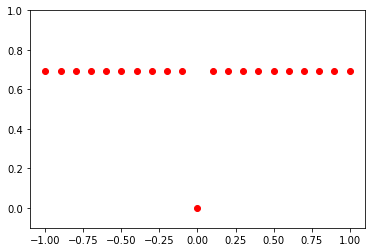

In [0]:
import matplotlib.pyplot as plt
plt.plot([j/10 for j in range(-10,11)],loss_JSD, 'ro')
plt.axis([-1.1, 1.1, -0.1, 1])
plt.show()

**part1-2  implement WD**

**part 1-3  plot WD for different theta**

In [0]:
import torch.nn as nn
import torch.nn.functional as F

def WD(Dx, Dy, dz, lambda_=10):
  """
  Input: Dx,Dy,lambda = 10
  Output:asserstein Distance of inputs
  The main idea for this question is to use gradient penalty over Z = a*x +(1-a)y
  """
  wd = torch.mean(Dx) - torch.mean(Dy) - lambda_*torch.mean((torch.norm(dz, dim=1)-1)**2)
  return -wd

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer = nn.Linear(2, 32)
        self.output_layer = nn.Linear(32, 1)
        
    def forward(self, x):
        x = F.relu(self.hidden_layer(x))
        x = self.output_layer(x)
        return x

In [0]:
loss_WD = []
for j in range(-10, 11):
    net = Net()
    net.apply(init_weights)
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    for i in range(5000):
        x = torch.tensor(next(iter(distribution1(0, batch_size=512))), dtype=torch.float32)
        y = torch.tensor(next(iter(distribution1(j/10, batch_size=512))), dtype=torch.float32)
        a = torch.tensor(next(iter(distribution0(batch_size=512))), dtype=torch.float32)
        
        z = a*x + (1-a)*y
        z.retain_grad()
        z.requires_grad = True
        
        Dz = net(z)
        Dx = net(x)
        Dy = net(y)
        
        dz = torch.autograd.grad(Dz, z, grad_outputs=torch.ones_like(Dz), create_graph=True, retain_graph=True)[0]
        loss = WD(Dx, Dy, dz)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    loss_WD.append(-loss.item())
    print('loss:',-loss.item())

loss: 1.0256867408752441
loss: 0.9206493496894836
loss: 0.8158242702484131
loss: 0.7126677632331848
loss: 0.60908442735672
loss: 0.5034850239753723
loss: 0.40397095680236816
loss: 0.30232107639312744
loss: 0.20084305107593536
loss: 0.10005880892276764
loss: 0.0014273073757067323
loss: 0.10039763152599335
loss: 0.20117312669754028
loss: 0.30179286003112793
loss: 0.4037764370441437
loss: 0.506388783454895
loss: 0.6088544726371765
loss: 0.7123255729675293
loss: 0.8160541653633118
loss: 0.9200828075408936
loss: 1.0250868797302246


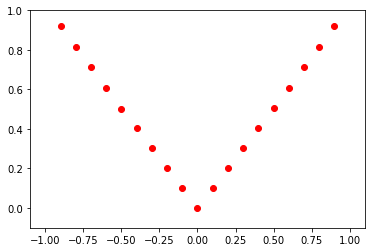

In [0]:
plt.plot([j/10 for j in range(-10,11)],loss_WD, 'ro')
plt.axis([-1.1, 1.1, -.1, 1])
plt.show()

## **part 1-4**

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Text(0.5, 1.0, 'Estimated vs True')

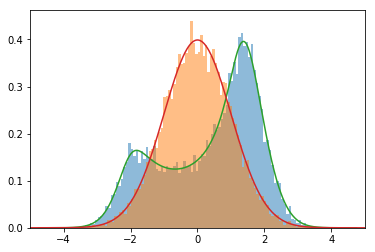

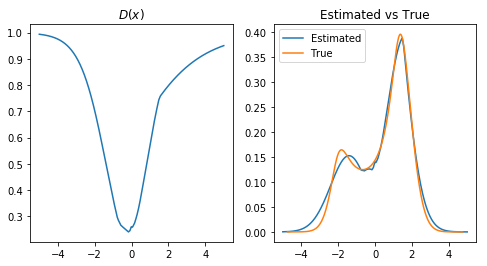

In [38]:
from __future__ import print_function
import numpy as np
import torch 
import matplotlib.pyplot as plt

# plot p0 and p1
plt.figure()


# empirical
xx = torch.randn(10000)
f = lambda x: torch.tanh(x*2+1) + x*0.75
d = lambda x: (1-torch.tanh(x*2+1)**2)*2+0.75
plt.hist(f(xx), 100, alpha=0.5, density=1)
plt.hist(xx, 100, alpha=0.5, density=1)
plt.xlim(-5,5)
# exact
xx = np.linspace(-5,5,1000)
N = lambda x: np.exp(-x**2/2.)/((2*np.pi)**0.5)
plt.plot(f(torch.from_numpy(xx)).numpy(), d(torch.from_numpy(xx)).numpy()**(-1)*N(xx))
plt.plot(xx, N(xx))


############### import the sampler ``samplers.distribution4'' 
############### train a discriminator on distribution4 and standard gaussian
############### estimate the density of distribution4
def JSD(Dx, Dy):
    """
    input:Dx,Dy
    output:Jensen-Shannon Divergence between 2 distribution Dx, Dy 

    """
    jsd = torch.mean(torch.log(Dx)) + torch.mean(torch.log(1-Dy))
    return -jsd

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer = nn.Linear(1, 32)
        self.output_layer = nn.Linear(32, 1)
        
    def forward(self, x):
        x = F.relu(self.hidden_layer(x))
        x = F.sigmoid(self.output_layer(x))
        return x

net = Net()
net.apply(init_weights)
optimizer = optim.Adam(net.parameters(), lr=0.001)
for i in range(5000):
    x = torch.tensor(next(iter(distribution4(batch_size=512))), dtype=torch.float32)
    y = torch.tensor(next(iter(distribution3(batch_size=512))), dtype=torch.float32)

    Dx = net(x)
    Dy = net(y)

    loss = JSD(Dx, Dy)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
loss_JSD.append(-loss.item())
#print('loss:',-loss.item())
#######--- INSERT YOUR CODE BELOW ---#######
"""
D_opt: output of discriminator
input: torch.linspace (-5,5,512)
outpt: torch.tensor (512,1)

"""
pp = torch.linspace(-5,5,512).view(512,1)
xx = np.linspace(-5,5,512)
D_opt = net(pp).detach().numpy()
r = xx # evaluate xx using your discriminator; replace xx with the output
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(r ,D_opt )
plt.title(r'$D(x)$')

"""
estimate: f_0*D_opt/(1-D_opt)
this is a formula in question 5 theory

"""

f_0 =  np.stack((N(xx),np.ones(len(N(xx)))),axis=1)
estimate = f_0*D_opt/(1-D_opt)  # estimate the density of distribution4 (on xx) using the discriminator; 
                                                                          # replace "np.ones_like(xx)*0." with your estimate
plt.subplot(1,2,2)
plt.plot(xx,estimate[:,0])
plt.plot(f(torch.from_numpy(xx)).numpy(), d(torch.from_numpy(xx)).numpy()**(-1)*N(xx))
plt.legend(['Estimated','True'])
plt.title('Estimated vs True')



